# Tiền xử lý

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import pickle
from scipy import sparse
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/năm 4/Hệ hỗ trợ quyết định/Tìm hiểu/Data/'

ratings = pd.read_csv(data_path + 'ratings.csv')
movies = pd.read_csv(data_path + 'movies.csv')
links = pd.read_csv(data_path + 'links.csv')
tags = pd.read_csv(data_path + 'tags.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
top_users = ratings['userId'].value_counts().nlargest(200).index
top_movies = ratings['movieId'].value_counts().nlargest(50).index
filtered_ratings = ratings[ratings['userId'].isin(top_users) & ratings['movieId'].isin(top_movies)].copy()
filtered_ratings['userId'] = filtered_ratings['userId'].astype('category').cat.codes
filtered_ratings['movieId'] = filtered_ratings['movieId'].astype('category').cat.codes

In [ ]:
filtered_ratings

,userId,movieId,rating,timestamp
159096,0,0,4.0,1619382182
159103,0,1,5.0,1619382182
159105,0,2,4.5,1619381466
159106,0,3,4.5,1619378551
159114,0,4,3.0,1619381471
...,...,...,...,...
31942801,199,45,4.5,1326447173
31942873,199,46,4.0,1544933125
31943023,199,47,4.0,1326447178
31943747,199,48,4.5,1326446513


In [ ]:
# filtered_ratings.to_csv(data_path + 'ratings_movies.csv')
filtered_ratings.to_csv('ratings_movies.csv')

# Đọc dữ liệu

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/năm 4/Hệ hỗ trợ quyết định/Tìm hiểu/Data/'  # Change this to your data folder in Google Drive

Mounted at /content/drive


In [6]:
filtered_ratings = pd.read_csv(data_path + 'ratings_movies.csv')

In [ ]:
# import pandas as pd
# import numpy as np
# filtered_ratings = pd.read_csv('ratings_movies.csv')

# Exact Interference

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
class Factor:
    def __init__(self, vars, table):
        """Khởi tạo Factor."""
        self.vars = vars  # Danh sách các biến trong bảng xác suất
        self.table = table  # Mảng numpy dày đặc (dense) biểu diễn xác suất

        # Đảm bảo số lượng biến phù hợp với số chiều của bảng
        if len(vars) != len(table.shape):
            raise ValueError(f"Các biến {vars} không khớp với số chiều của bảng {table.shape}")

    def multiply(self, other):
        """Nhân hai factor và trả về kết quả."""
        # Xác định các biến chung và tất cả các biến
        common_vars = list(set(self.vars) & set(other.vars))
        if not common_vars:
            raise ValueError("Hai factor không có biến chung để nhân.")

        all_vars = self.vars + [var for var in other.vars if var not in self.vars]

        # Tạo ánh xạ chỉ mục của các biến
        self_indices = {var: idx for idx, var in enumerate(self.vars)}
        other_indices = {var: idx for idx, var in enumerate(other.vars)}
        all_indices = {var: idx for idx, var in enumerate(all_vars)}

        # Tính hình dạng của kết quả dựa trên tất cả các biến
        result_shape = [
            self.table.shape[self_indices[var]] if var in self.vars else other.table.shape[other_indices[var]]
            for var in all_vars
        ]

        # Mở rộng các chiều của bảng để khớp với danh sách biến kết hợp
        self_table_expanded = self.table
        other_table_expanded = other.table

        for var in all_vars:
            if var not in self.vars:
                axis = all_indices[var]
                self_table_expanded = np.expand_dims(self_table_expanded, axis=axis)
            if var not in other.vars:
                axis = all_indices[var]
                other_table_expanded = np.expand_dims(other_table_expanded, axis=axis)

        # Thực hiện nhân từng phần tử
        result_table = self_table_expanded * other_table_expanded

        # Trả về factor mới với các biến kết hợp
        return Factor(all_vars, result_table)

    def marginalize(self, var_to_remove):
        """Lấy tổng (sum out) trên một biến."""
        if var_to_remove not in self.vars:
            raise KeyError(f"Biến {var_to_remove} không được tìm thấy trong {self.vars}")
        idx = self.vars.index(var_to_remove)
        other_vars = [v for v in self.vars if v != var_to_remove]

        # Lấy tổng trên trục chỉ định
        table = self.table.sum(axis=idx)
        return Factor(other_vars, table)

    def condition(self, evidence):
        """Điều kiện hóa factor dựa trên bằng chứng."""
        conditioned_table = self.table
        for var, value in evidence.items():
            if var in self.vars:
                idx = self.vars.index(var)
                if value >= conditioned_table.shape[idx] or value < 0:
                    raise IndexError(f"Giá trị {value} của biến {var} vượt quá giới hạn.")
                conditioned_table = np.take(conditioned_table, indices=value, axis=idx)
            else:
                raise KeyError(f"Biến {var} không tồn tại trong danh sách biến của factor: {self.vars}")
        remaining_vars = [var for var in self.vars if var not in evidence]
        return Factor(remaining_vars, conditioned_table)

    def normalize(self):
        """Chuẩn hóa factor để đảm bảo tổng các xác suất bằng 1."""
        total = self.table.sum()
        if total != 0:
            self.table = self.table / total

In [8]:
# Định nghĩa thang điểm đánh giá
rating_scale = np.arange(0, 5.5, 0.5)  # {0, 0.5, 1, ..., 5}

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_ratio = 0.8
train_data, test_data = train_test_split(filtered_ratings, test_size=(1 - train_ratio), random_state=42)

In [9]:
# Chuẩn bị các ma trận xác suất
user_movie_counts = train_data.groupby(['userId', 'movieId']).size().reset_index(name='count')
total_ratings_per_user = user_movie_counts.groupby('userId')['count'].sum().reset_index()
total_ratings_per_user.columns = ['userId', 'total_count']

In [10]:
total_ratings_per_user

,userId,total_count
0,0,34
1,1,37
2,2,37
3,3,42
4,4,33
...,...,...
195,195,37
196,196,38
197,197,41
198,198,42


In [11]:
user_movie_counts = pd.merge(user_movie_counts, total_ratings_per_user, on='userId')
user_movie_counts['probability'] = user_movie_counts['count'] / user_movie_counts['total_count']


In [12]:
user_movie_counts

,userId,movieId,count,total_count,probability
0,0,0,1,34,0.029412
1,0,1,1,34,0.029412
2,0,2,1,34,0.029412
3,0,4,1,34,0.029412
4,0,5,1,34,0.029412
...,...,...,...,...,...
7515,199,42,1,38,0.026316
7516,199,44,1,38,0.026316
7517,199,46,1,38,0.026316
7518,199,47,1,38,0.026316


In [13]:
# Tạo mapping người dùng và phim
user_ids = user_movie_counts['userId'].unique()
movie_ids = user_movie_counts['movieId'].unique()
user_mapping = {user: idx for idx, user in enumerate(user_ids)}
movie_mapping = {movie: idx for idx, movie in enumerate(movie_ids)}

# Chuyển đổi movieId và userId thành indices
row_indices = user_movie_counts['movieId'].map(movie_mapping).fillna(-1).astype(int)
col_indices = user_movie_counts['userId'].map(user_mapping).fillna(-1).astype(int)

In [14]:
row_indices

,movieId
0,0
1,1
2,2
3,3
4,4
...,...
7515,27
7516,28
7517,30
7518,31


In [15]:
valid_rows = (row_indices >= 0) & (col_indices >= 0)
valid_rows

,0
0,True
1,True
2,True
3,True
4,True
...,...
7515,True
7516,True
7517,True
7518,True


In [16]:
row_indices = row_indices[valid_rows]
col_indices = col_indices[valid_rows]
# xác suất từ các hàng hợp lệ trong user_movie_counts
data = user_movie_counts.loc[valid_rows, 'probability']
data

,probability
0,0.029412
1,0.029412
2,0.029412
3,0.029412
4,0.029412
...,...
7515,0.026316
7516,0.026316
7517,0.026316
7518,0.026316


In [17]:
prob_movie_given_user = Factor(
    ['Movie', 'User'],
    np.zeros((len(movie_ids), len(user_ids)))  # Khởi tạo ma trận P(movie|user)
)

for i, j, val in zip(row_indices, col_indices, data):
    prob_movie_given_user.table[i, j] = val

In [18]:
##Tương tự
movie_rating_counts = train_data.groupby(['movieId', 'rating']).size().reset_index(name='count')
total_ratings_per_movie = movie_rating_counts.groupby('movieId')['count'].sum().reset_index()
movie_rating_counts = pd.merge(movie_rating_counts, total_ratings_per_movie, on='movieId')
movie_rating_counts['probability'] = movie_rating_counts['count_x'] / movie_rating_counts['count_y']

row_indices = movie_rating_counts['rating'].astype('category').cat.codes
col_indices = movie_rating_counts['movieId'].map(movie_mapping).fillna(-1).astype(int)

valid_rows = col_indices >= 0
row_indices = row_indices[valid_rows]
col_indices = col_indices[valid_rows]
data = movie_rating_counts.loc[valid_rows, 'probability']

prob_rating_given_movie = Factor(
    ['Rating', 'Movie'],
    np.zeros((len(rating_scale), len(movie_ids)))  # Khởi tạo ma trận  P(rating|movie)
)

for i, j, val in zip(row_indices, col_indices, data):
    prob_rating_given_movie.table[i, j] = val


In [19]:
print("Shape of prob_rating_given_movie.table:", prob_rating_given_movie.table.shape)
print("Shape of prob_movie_given_user.table:", prob_movie_given_user.table.shape)


Shape of prob_rating_given_movie.table: (11, 50)
Shape of prob_movie_given_user.table: (50, 200)


In [20]:
# Suy diễn P(Rating | User, Movie)
joint_factor = prob_rating_given_movie.multiply(prob_movie_given_user)
query_evidence = {"User": 1, "Movie": 32}

# Ánh xạ giá trị bằng chứng sang chỉ mục
query_evidence_mapped = {
    "User": user_mapping.get(query_evidence["User"], -1),
    "Movie": movie_mapping.get(query_evidence["Movie"], -1),
}

if -1 in query_evidence_mapped.values():
    raise ValueError("Bằng chứng chứa chỉ mục người dùng hoặc phim không hợp lệ.")
# Condition
conditioned_factor = joint_factor.condition(query_evidence_mapped)
conditioned_factor.normalize()

In [21]:
print("Shape of joint_factor.table:", joint_factor.table.shape)

Shape of joint_factor.table: (11, 50, 200)


Xếp hạng dự đoán: 4.5


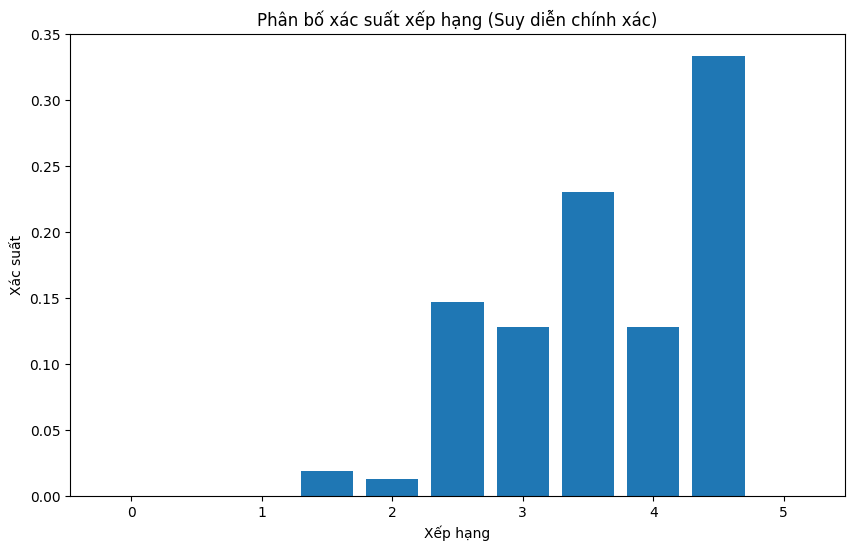

In [ ]:
predicted_index = np.argmax(conditioned_factor.table)
predicted_rating = rating_scale[predicted_index]
print(f"Xếp hạng dự đoán: {predicted_rating}")

# Trực quan hóa phân bố xác suất
plt.figure(figsize=(10, 6))
plt.bar(
    rating_scale,
    conditioned_factor.table,
    width=0.4,
    align='center'
)
plt.xlabel("Xếp hạng")
plt.ylabel("Xác suất")
plt.title("Phân bố xác suất xếp hạng (Suy diễn chính xác)")
plt.show()


In [ ]:
# Tính RMSE
test_predictions = []
test_actuals = test_data['rating'].values

for _, row in test_data.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']

    evidence = {
        "User": user_mapping.get(user_id, -1),
        "Movie": movie_mapping.get(movie_id, -1),
    }

    if -1 in evidence.values():
        test_predictions.append(0)  # Thêm giá trị mặc định (ví dụ: 0)
        continue

    conditioned = joint_factor.condition(evidence)
    conditioned.normalize()

    predicted_index = np.argmax(conditioned.table)
    predicted = rating_scale[predicted_index]  # Ánh xạ sang thang xếp hạng thực
    test_predictions.append(predicted)

rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
print(f"RMSE: {rmse:.4f}")

RMSE: 3.9752


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Naive Bayes

In [ ]:
# Bước 3: Tính xác suất tiên nghiệm (P(C))
rating_counts = train_data['rating'].value_counts().reindex(rating_scale, fill_value=0)
P_C = (rating_counts / rating_counts.sum()).values  # Chuẩn hóa để có xác suất


In [ ]:
# Bước 1: Nhóm dữ liệu để tính số lượng người dùng theo từng mức đánh giá (rating)
rating_user_counts = train_data.groupby(['rating', 'userId']).size().reset_index(name='count')
total_users_per_rating = rating_user_counts.groupby('rating')['count'].sum().reset_index()
total_users_per_rating.columns = ['rating', 'total_count']

# Bước 2: Tính xác suất P(user | rating)
rating_user_counts = pd.merge(rating_user_counts, total_users_per_rating, on='rating')
rating_user_counts['probability'] = rating_user_counts['count'] / rating_user_counts['total_count']

# Bước 3: Chuyển đổi rating và userId thành các chỉ mục tương ứng
rating_user_counts['rating_cat'] = pd.Categorical(rating_user_counts['rating'], categories=rating_scale).codes
rating_user_counts['userId_cat'] = pd.Categorical(rating_user_counts['userId'], categories=user_ids).codes

row_indices = rating_user_counts['rating_cat'].values  # Rating là hàng
col_indices = rating_user_counts['userId_cat'].values  # User là cột
data = rating_user_counts['probability'].values

# Bước 4: Khởi tạo ma trận P(user | rating)
prob_user_given_rating = Factor(
    ['Rating', 'User'],
    np.zeros((len(rating_scale), len(user_ids)))  # Khởi tạo ma trận P(user|rating)
)

# Bước 5: Điền dữ liệu vào ma trận
for i, j, val in zip(row_indices, col_indices, data):
    prob_user_given_rating.table[i, j] = val  # Rating là hàng (i), User là cột (j)


In [ ]:
# Bước 1: Nhóm dữ liệu để tính số lượng phim theo từng mức đánh giá (rating)
rating_movie_counts = train_data.groupby(['rating', 'movieId']).size().reset_index(name='count')
total_movies_per_rating = rating_movie_counts.groupby('rating')['count'].sum().reset_index()
total_movies_per_rating.columns = ['rating', 'total_count']

# Bước 2: Tính xác suất P(movie | rating)
rating_movie_counts = pd.merge(rating_movie_counts, total_movies_per_rating, on='rating')
rating_movie_counts['probability'] = rating_movie_counts['count'] / rating_movie_counts['total_count']

# Bước 3: Chuyển đổi rating và movieId thành các chỉ mục tương ứng
rating_movie_counts['rating_cat'] = pd.Categorical(rating_movie_counts['rating'], categories=rating_scale).codes
rating_movie_counts['movieId_cat'] = pd.Categorical(rating_movie_counts['movieId'], categories=movie_ids).codes

row_indices = rating_movie_counts['rating_cat'].values  # Rating là hàng
col_indices = rating_movie_counts['movieId_cat'].values  # Movie là cột
data = rating_movie_counts['probability'].values

# Bước 4: Khởi tạo ma trận P(movie | rating)
prob_movie_given_rating = Factor(
    ['Rating', 'Movie'],
    np.zeros((len(rating_scale), len(movie_ids)))  # Khởi tạo ma trận P(movie|rating)
)

# Bước 5: Điền dữ liệu vào ma trận
for i, j, val in zip(row_indices, col_indices, data):
    prob_movie_given_rating.table[i, j] = val  # Rating là hàng (i), Movie là cột (j)


In [ ]:
print(f"prob_user_given_rating.table shape: {prob_user_given_rating.table.shape}")
print(f"prob_movie_given_rating.table shape: {prob_movie_given_rating.table.shape}")

prob_user_given_rating.table shape: (11, 200)
prob_movie_given_rating.table shape: (11, 50)


In [ ]:
# Lọc tập kiểm tra
test_data_filtered = test_data[
    (test_data['userId'].isin(user_ids)) &
    (test_data['movieId'].isin(movie_ids))
]

predicted_ratings = []
true_ratings = []

for _, row in test_data_filtered.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    true_rating = row['rating']

    # Ánh xạ người dùng và phim tới các chỉ mục tương ứng
    try:
        user_idx = np.where(user_ids == user_id)[0][0]
        movie_idx = np.where(movie_ids == movie_id)[0][0]
    except IndexError:
        continue

    if user_idx >= prob_user_given_rating.table.shape[1]:
        continue
    if movie_idx >= prob_movie_given_rating.table.shape[1]:
        continue

    # Tính P(user | C) và P(movie | C)
    P_user_given_C = prob_user_given_rating.table[:, user_idx]
    P_movie_given_C = prob_movie_given_rating.table[:, movie_idx]

    # Tính xác suất kết hợp (P(C, O1:n))
    joint_prob = P_C * P_user_given_C * P_movie_given_C

    # Chuẩn hóa để lấy xác suất hậu nghiệm (P(C | O1:n))
    P_C_given_O = joint_prob / joint_prob.sum()

    # Xếp hạng dự đoán
    inferred_rating_idx = np.argmax(P_C_given_O)
    inferred_rating = rating_scale[inferred_rating_idx]

    predicted_ratings.append(inferred_rating)
    true_ratings.append(true_rating)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f"Root Mean Square Error (RMSE): {rmse}")


Root Mean Square Error (RMSE): 0.9735190607800793


# Direct Sampling

In [22]:
class Factor:
    def __init__(self, vars, table):
        self.vars = vars
        self.table = table
        if len(vars) != len(table.shape):
            raise ValueError(f"Variables {vars} do not match table dimensions {table.shape}")

    # Nhân hai factors
    def multiply(self, other):
        # Xác định các biến chung giữa hai factors
        common_vars = list(set(self.vars) & set(other.vars))
        all_vars = self.vars + [var for var in other.vars if var not in self.vars]

        # Lập chỉ mục cho từng factor
        self_indices = {var: idx for idx, var in enumerate(self.vars)}
        other_indices = {var: idx for idx, var in enumerate(other.vars)}
        all_indices = {var: idx for idx, var in enumerate(all_vars)}

        # Thay đổi hình dạng (reshape) để phù hợp với các biến
        self_shape = [self.table.shape[self_indices[var]] if var in self.vars else 1 for var in all_vars]
        self_aligned = np.reshape(self.table, self_shape)

        other_shape = [other.table.shape[other_indices[var]] if var in other.vars else 1 for var in all_vars]
        other_aligned = np.reshape(other.table, other_shape)

        # Nhân các bảng phân phối xác suất
        result_table = self_aligned * other_aligned
        return Factor(all_vars, result_table)

    # Chuẩn hóa factor
    def normalize(self):
        total = self.table.sum()
        if total != 0:
            self.table = self.table / total
        return self

    # Tổng biên (loại bỏ biến không liên quan)
    def marginalize(self, var_to_remove):
        if var_to_remove not in self.vars:
            raise KeyError(f"Variable {var_to_remove} not found in {self.vars}")
        idx = self.vars.index(var_to_remove)
        other_vars = [v for v in self.vars if v != var_to_remove]
        table = self.table.sum(axis=idx)
        return Factor(other_vars, table)

# Suy luận bằng phương pháp lấy mẫu (Sampling)
def infer(num_samples, bn, query, evidence):
    table = np.zeros(len(rating_scale))
    for _ in range(num_samples):
        # Lấy mẫu từ mạng Bayesian
        sampled_assignment = sample_from_bn(bn, evidence)
        if sampled_assignment is not None:
            value = sampled_assignment[query[0]]
            table[value] += 1
    table /= table.sum()  # Chuẩn hóa xác suất
    return Factor(query, table)

# Lấy mẫu từ mạng Bayesian
def sample_from_bn(bn, evidence):
    sample = {}
    for var in bn.vars:
        if var in evidence:
            sample[var] = evidence[var]
        else:
            probabilities = bn.table.sum(axis=tuple(idx for idx, v in enumerate(bn.vars) if v != var))
            probabilities /= probabilities.sum()
            sample[var] = np.random.choice(len(probabilities), p=probabilities)
    return sample

In [23]:
prob_movie_given_user = Factor(
    ["Movie", "User"],
    np.random.rand(len(movie_ids), len(user_ids))
)
prob_movie_given_user.normalize()

prob_rating_given_movie = Factor(
    ["Rating", "Movie"],
    np.random.rand(len(rating_scale), len(movie_ids))
)
prob_rating_given_movie.normalize()

# Nhân các factors để tạo factor kết hợp
joint_factor = prob_movie_given_user.multiply(prob_rating_given_movie)

In [25]:
# Dự đoán
evidence = {"User": 13, "Movie": 32}
conditioned_factor = infer(1000, joint_factor, ["Rating"], evidence)

predicted_index = np.argmax(conditioned_factor.table)
predicted_rating = rating_scale[predicted_index]
print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: 3.0


In [26]:
test_predictions = []
test_actuals = test_data['rating'].values

for _, row in test_data.iterrows():
    # Tạo bằng chứng (evidence) cho từng hàng dữ liệu kiểm tra
    evidence = {
        "User": user_mapping.get(row['userId'], -1),
        "Movie": movie_mapping.get(row['movieId'], -1),
    }
    if -1 in evidence.values():
        test_predictions.append(0)  # Gán giá trị mặc định nếu chỉ số không hợp lệ
        continue

    # Suy luận và dự đoán
    conditioned_factor = infer(1000, joint_factor, ["Rating"], evidence)
    predicted_index = np.argmax(conditioned_factor.table)
    predicted_rating = rating_scale[predicted_index]
    test_predictions.append(predicted_rating)

# Tính RMSE
rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 2.8092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
class Factor:
    def __init__(self, vars, table):
        self.vars = vars
        self.table = table
        if len(vars) != len(table.shape):
            raise ValueError(f"Variables {vars} do not match table dimensions {table.shape}")

    # Nhân hai factors
    def multiply(self, other):
        # Xác định các biến chung giữa hai factors
        common_vars = list(set(self.vars) & set(other.vars))
        all_vars = self.vars + [var for var in other.vars if var not in self.vars]

        # Lập chỉ mục cho từng factor
        self_indices = {var: idx for idx, var in enumerate(self.vars)}
        other_indices = {var: idx for idx, var in enumerate(other.vars)}
        all_indices = {var: idx for idx, var in enumerate(all_vars)}

        # Thay đổi hình dạng (reshape) để phù hợp với các biến
        self_shape = [self.table.shape[self_indices[var]] if var in self.vars else 1 for var in all_vars]
        self_aligned = np.reshape(self.table, self_shape)

        other_shape = [other.table.shape[other_indices[var]] if var in other.vars else 1 for var in all_vars]
        other_aligned = np.reshape(other.table, other_shape)

        # Nhân các bảng phân phối xác suất
        result_table = self_aligned * other_aligned
        return Factor(all_vars, result_table)

    # Chuẩn hóa factor
    def normalize(self):
        total = self.table.sum()
        if total != 0:
            self.table = self.table / total
        return self

    # Tổng biên (loại bỏ biến không liên quan)
    def marginalize(self, var_to_remove):
        if var_to_remove not in self.vars:
            raise KeyError(f"Variable {var_to_remove} not found in {self.vars}")
        idx = self.vars.index(var_to_remove)
        other_vars = [v for v in self.vars if v != var_to_remove]
        table = self.table.sum(axis=idx)
        return Factor(other_vars, table)

# Suy luận bằng phương pháp lấy mẫu (Sampling)
def infer(num_samples, bn, query, evidence):
    table = np.zeros(len(rating_scale))
    for _ in range(num_samples):
        # Lấy mẫu từ mạng Bayesian
        sampled_assignment = sample_from_bn(bn, evidence)
        if sampled_assignment is not None:
            value = sampled_assignment[query[0]]
            table[value] += 1
    table /= table.sum()  # Chuẩn hóa xác suất
    return Factor(query, table)

# Lấy mẫu từ mạng Bayesian
def sample_from_bn(bn, evidence):
    sample = {}
    for var in bn.vars:
        if var in evidence:
            sample[var] = evidence[var]
        else:
            probabilities = bn.table.sum(axis=tuple(idx for idx, v in enumerate(bn.vars) if v != var))
            probabilities /= probabilities.sum()
            sample[var] = np.random.choice(len(probabilities), p=probabilities)
    return sample

# Chuẩn bị các factors
user_ids = train_data['userId'].unique()
movie_ids = train_data['movieId'].unique()
rating_ids = train_data['rating'].unique()

user_mapping = {user: idx for idx, user in enumerate(user_ids)}
movie_mapping = {movie: idx for idx, movie in enumerate(movie_ids)}

# Xác suất điều kiện "Phim dựa trên người dùng"
prob_movie_given_user = Factor(
    ["Movie", "User"],
    np.random.rand(len(movie_ids), len(user_ids))
)
prob_movie_given_user.normalize()

# Xác suất điều kiện "Đánh giá dựa trên phim"
prob_rating_given_movie = Factor(
    ["Rating", "Movie"],
    np.random.rand(len(rating_scale), len(movie_ids))
)
prob_rating_given_movie.normalize()

# Nhân các factors để tạo factor kết hợp
joint_factor = prob_movie_given_user.multiply(prob_rating_given_movie)

# Dự đoán
evidence = {"User": 1, "Movie": 32}
conditioned_factor = infer(1000, joint_factor, ["Rating"], evidence)

predicted_index = np.argmax(conditioned_factor.table)
predicted_rating = rating_scale[predicted_index]
print(f"Predicted Rating: {predicted_rating}")

# Tính toán RMSE (Root Mean Square Error)
test_predictions = []
test_actuals = test_data['rating'].values

for _, row in test_data.iterrows():
    # Tạo bằng chứng (evidence) cho từng hàng dữ liệu kiểm tra
    evidence = {
        "User": user_mapping.get(row['userId'], -1),
        "Movie": movie_mapping.get(row['movieId'], -1),
    }
    if -1 in evidence.values():
        test_predictions.append(0)  # Gán giá trị mặc định nếu chỉ số không hợp lệ
        continue

    # Suy luận và dự đoán
    conditioned_factor = infer(1000, joint_factor, ["Rating"], evidence)
    predicted_index = np.argmax(conditioned_factor.table)
    predicted_rating = rating_scale[predicted_index]
    test_predictions.append(predicted_rating)

# Tính RMSE (sai số trung bình bình phương)
rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
print(f"Test RMSE: {rmse:.4f}")


Predicted Rating: 3.0
Test RMSE: 2.0988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Gaussian

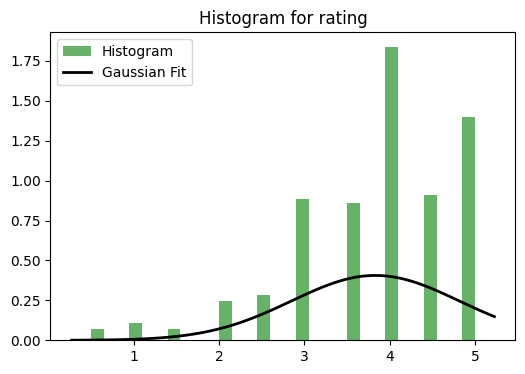

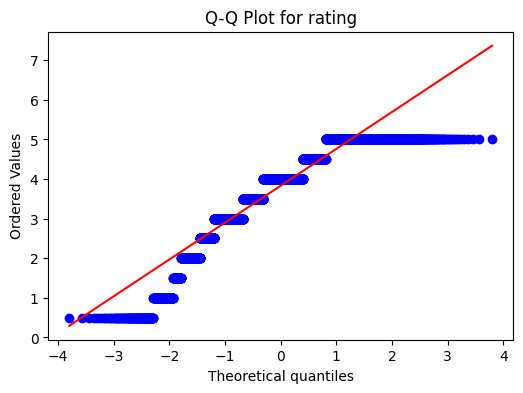

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9400.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for rating: Statistic=0.898507802902847, p-value=2.0105505919954713e-61
rating does NOT appear Gaussian (p-value <= 0.05).



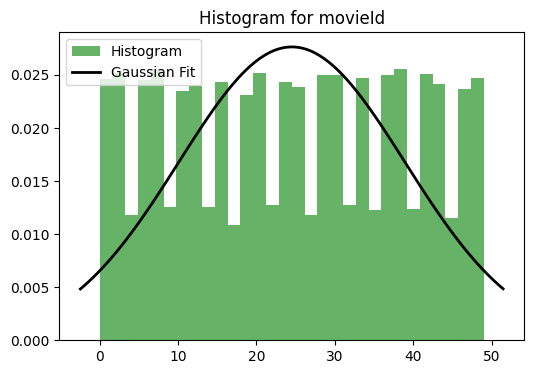

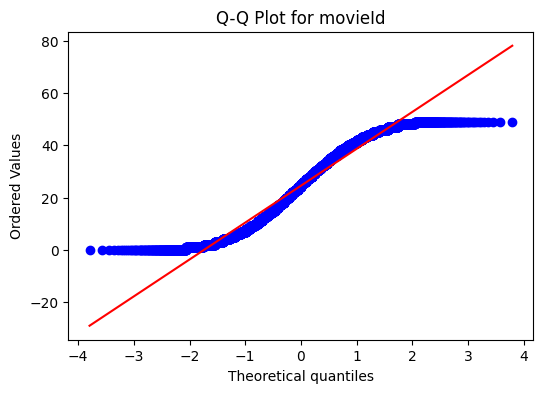

Shapiro-Wilk Test for movieId: Statistic=0.9536476662105633, p-value=2.589842694863688e-47
movieId does NOT appear Gaussian (p-value <= 0.05).



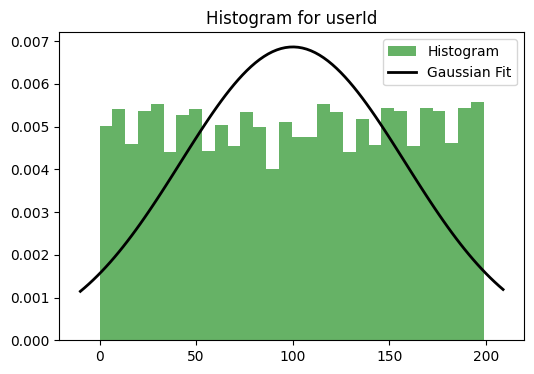

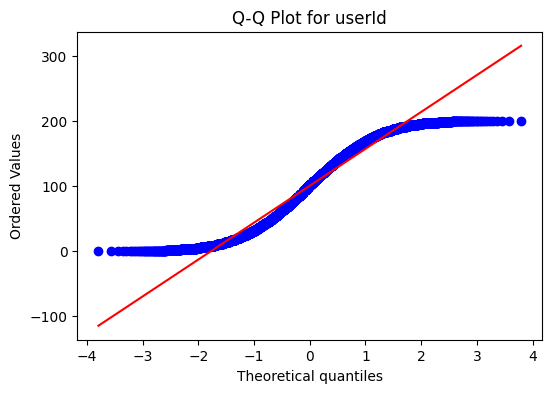

Shapiro-Wilk Test for userId: Statistic=0.9527436234774194, p-value=1.225493143124703e-47
userId does NOT appear Gaussian (p-value <= 0.05).



In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Check marginal normality for each feature
for i, column in enumerate(['rating', 'movieId', 'userId']):
    data = features[:, i]

    # Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Histogram')

    # Plot Gaussian PDF for comparison
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(data), np.std(data))
    plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
    plt.title(f"Histogram for {column}")
    plt.legend()
    plt.show()

    # Q-Q Plot
    plt.figure(figsize=(6, 4))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

    # Shapiro-Wilk Test
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk Test for {column}: Statistic={stat}, p-value={p_value}")
    if p_value > 0.05:
        print(f"{column} appears Gaussian (p-value > 0.05).\n")
    else:
        print(f"{column} does NOT appear Gaussian (p-value <= 0.05).\n")


In [4]:
import pandas as pd
import numpy as np


features = filtered_ratings[['rating', 'movieId', 'userId']].values

mean_vector = np.mean(features, axis=0)

covariance_matrix = np.cov(features.T)

print("Mean Vector:", mean_vector)
print("Covariance Matrix:")
print(covariance_matrix)


Mean Vector: [  3.83196809  24.51819149 100.08074468]
Covariance Matrix:
[[ 9.64873241e-01 -1.54911857e-01 -9.22328309e-01]
 [-1.54911857e-01  2.08417799e+02 -3.42728731e-01]
 [-9.22328309e-01 -3.42728731e-01  3.38006636e+03]]


In [6]:
def infer(mean_vector, covariance_matrix, query, evidence_vars, evidence_values):
    μ = mean_vector
    Σ = covariance_matrix

    # Trích xuất các ma trận con và vector con
    μ_query = μ[query]  # Kỳ vọng của biến cần truy vấn
    μ_evidence = μ[evidence_vars]  # Kỳ vọng của các biến chứng cứ
    Σ_query_query = Σ[np.ix_(query, query)]  # Ma trận hiệp phương sai của biến cần truy vấn
    Σ_evidence_evidence = Σ[np.ix_(evidence_vars, evidence_vars)]  # Ma trận hiệp phương sai của các biến chứng cứ
    Σ_query_evidence = Σ[np.ix_(query, evidence_vars)]  # Ma trận hiệp phương sai giữa biến truy vấn và biến chứng cứ

    # Tính toán kỳ vọng hậu nghiệm và ma trận hiệp phương sai hậu nghiệm
    μ_posterior = μ_query + Σ_query_evidence @ np.linalg.solve(Σ_evidence_evidence, evidence_values - μ_evidence)
    Σ_posterior = Σ_query_query - Σ_query_evidence @ np.linalg.solve(Σ_evidence_evidence, Σ_query_evidence.T)

    return μ_posterior, Σ_posterior

query = [0]
evidence_vars = [1, 2]
evidence_values = np.array([1, 32])

# Thực hiện suy luận
μ_posterior, Σ_posterior = infer(mean_vector, covariance_matrix, query, evidence_vars, evidence_values)

# Hiển thị kết quả
print("Kỳ vọng hậu nghiệm (Dự đoán):", μ_posterior)
print("Ma trận hiệp phương sai hậu nghiệm:", Σ_posterior)


Kỳ vọng hậu nghiệm (Dự đoán): [3.86804166]
Ma trận hiệp phương sai hậu nghiệm: [[0.96450628]]


Trên thang điểm 5, 0.96 thể hiện khả năng không chắc chắn về kết quả dự đoán ở mức trung bình